In [ ]:
!pip install --upgrade networkx

In [13]:
from IPython.core.display import HTML
from datascience import *

import matplotlib
from matplotlib import animation as animation
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
plt.style.use('fivethirtyeight')

import networkx as nx
import pandas as pd

# suppress annoying matplotlib warnings
import warnings
warnings.filterwarnings("ignore")

In [14]:
# this has some functions we'll use to simulate simple SIR outbreaks
import sir_code.sir_code as sir

## Simulating SIR outbreaks in a small world

In this demo, we'll explore some simulations based on a simple contagion that breaks out in a Watts-Strogatz small world network.

**Simulating an SIR outbreak on a network**

Rough outline (you'll see more detail in lab next week):

* randomly pick a starting node to infect

* while any infected:
    * get neighbors of infected
    * set infected to recovered
    * neighbors become infected with prob beta * number of infected contacts
    * record how many were infected

### SIR model: illustration

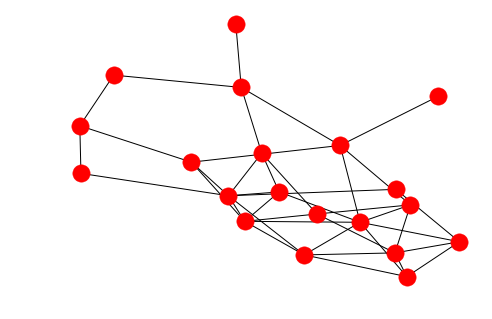

In [15]:
np.random.seed(seed=101)
er_net_example = nx.erdos_renyi_graph(n=20, p=.2)

nx.draw(er_net_example)

[1, 3, 6, 3, 0]

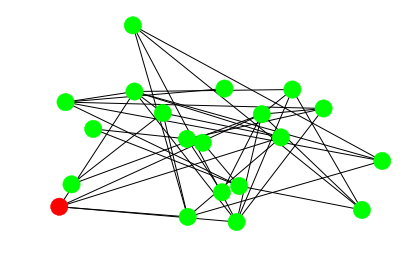

<Figure size 432x288 with 0 Axes>

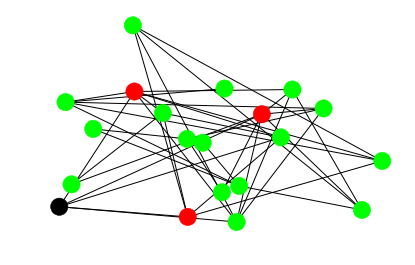

<Figure size 432x288 with 0 Axes>

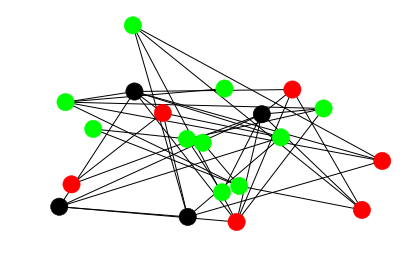

<Figure size 432x288 with 0 Axes>

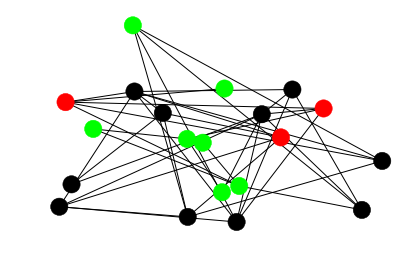

<Figure size 432x288 with 0 Axes>

In [16]:
np.random.seed(seed=100)
res = sir.sim_epidemic(er_net_example, beta=.3, draw=True)
res

### Generating Watts-Strogatz networks

Try re-running the cell below a few different times, changing the value of the rewiring parameter (`p`) each time. (Note: confusingly, what the `networkx` package calls `p` is the `beta` parameter in the original WS model.)

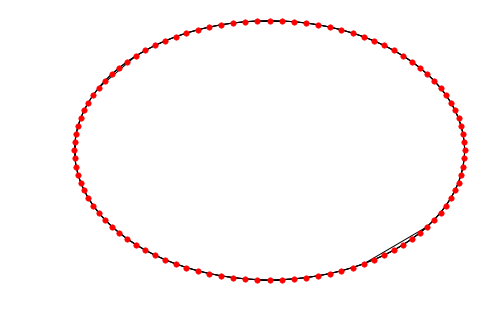

In [17]:
cur_ws_net = nx.generators.connected_watts_strogatz_graph(n=100, k=4, p=.01)
nx.draw(cur_ws_net, pos=nx.circular_layout(cur_ws_net), node_size=30)

## Threshold infectiousness for an SIR outbreak in the Watts-Strogatz model

In [18]:
%%time
ws_n = 400 # number of nodes in each network
ws_k = 4   # number of lattice neighbors each node starts out connected to

# range of rewiring parameter values to explore
p_vals = np.arange(0.0, 1.0, 0.1)
# range of infectiousness values to explore
beta_vals = np.arange(0.05, 1, 0.05)
# number of times to repeat each scenario
M = 50

sim_results = np.array([])

for cur_p in p_vals:
    for cur_beta in beta_vals:
        for idx in np.arange(M):
            cur_ws_net = nx.generators.connected_watts_strogatz_graph(n=ws_n, k=ws_k, p=cur_p)
            sir_res = sir.sim_epidemic(cur_ws_net, beta=cur_beta)
            frac_infected = np.sum(sir_res) / ws_n
            sim_results = np.append(sim_results, 
                                    [cur_p, cur_beta, idx, frac_infected], 
                                    axis=0)

sim_results = sim_results.reshape(-1,4)

CPU times: user 3min 20s, sys: 939 ms, total: 3min 21s
Wall time: 3min 25s


In [19]:
results = pd.DataFrame.from_records(sim_results,
                                    columns=['p', 'beta', 'idx', 'frac_infected'])
results.head()

,p,beta,idx,frac_infected
0,0.0,0.05,0.0,0.0025
1,0.0,0.05,1.0,0.0025
2,0.0,0.05,2.0,0.0025
3,0.0,0.05,3.0,0.0025
4,0.0,0.05,4.0,0.0025


In [20]:
results_agg = results.groupby(['p', 'beta']).agg({'frac_infected' : np.mean}).reset_index()
results_agg.head()

,p,beta,frac_infected
0,0.0,0.05,0.00310
1,0.0,0.10,0.00395
2,0.0,0.15,0.00505
3,0.0,0.20,0.00795
4,0.0,0.25,0.00815


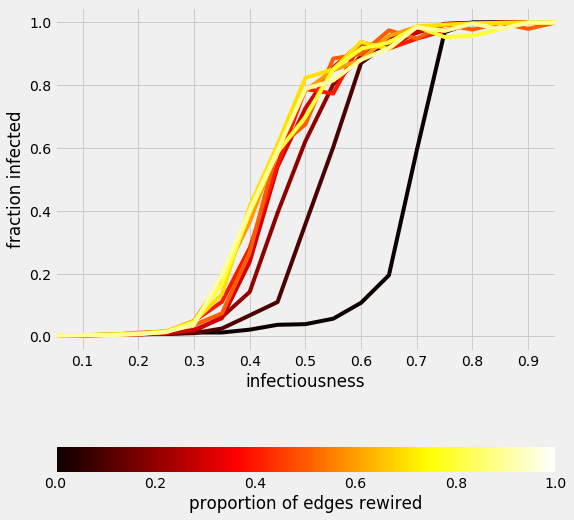

In [26]:
fig, ax = plt.subplots(2,1, 
                       figsize=(8,8),
                       gridspec_kw = {'height_ratios' : [12,1], 'hspace' : 0.5})

cmap = matplotlib.cm.hot

for key, df in results_agg.groupby(['p']):
    col = cmap(np.float(key))
    df.plot(ax=ax[0], kind='line', x='beta', y='frac_infected', 
            c=col,
            legend=False)

norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
cb = matplotlib.colorbar.ColorbarBase(ax[1], cmap=cmap, norm=norm, orientation='horizontal')
cb.set_label('proportion of edges rewired')

ax[0].set_ylabel('fraction infected')
ax[0].set_xlabel('infectiousness');
ax[0].set_title('');

Let's calculate the estimated level of infectiousness at which half of the population becomes infected (on average).

In [27]:
def get_thresh_inf(x):
    x = x.sort_values(by=['beta']) # be sure df is sorted by infectiousness param
    idx = np.argmax(x['frac_infected'] >= 0.5) # returns first index that satisfies predicate
    inf_value = x['beta'][idx]
    return(pd.Series({'threshold_infectiousness' : inf_value }))

In [28]:
ti_vals = results_agg.groupby(['p']).apply(get_thresh_inf).reset_index()
ti_vals

,p,threshold_infectiousness
0,0.0,0.70
1,0.1,0.55
2,0.2,0.50
3,0.3,0.45
4,0.4,0.45
5,0.5,0.45
6,0.6,0.45
7,0.7,0.45
8,0.8,0.45
9,0.9,0.45


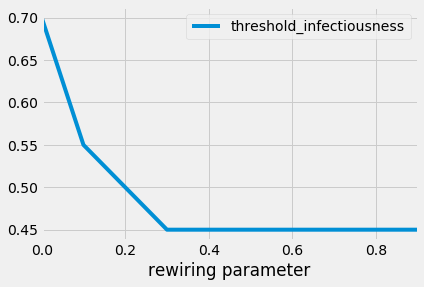

In [29]:
ti_vals.plot(x='p', y='threshold_infectiousness');
plt.xlabel('rewiring parameter');